In [55]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [56]:
inputs = [[1,2,3.5,1.25],
          [2.1, 1.35, -0.25, 3],
          [4.8, 0.9, 3.1, 0.2],
          [1.45, -0.95, 0.80, 1]]

weights = [[0.2, 0.8, -0.5, 1.0],
          [0.32, -0.85, 0.12, 1.25],
          [-0.25, 1.32, 0.19, 2.2]]

biases = [2.0, 3.0, -5.0]

# .T here means we're taking the transpose of the matrix.
# Since we're doing matrix multiplication here.
outputs = np.dot(inputs, np.array(weights).T) + biases
print(outputs)

[[ 3.3     3.6025  0.805 ]
 [ 6.625   6.2445  2.8095]
 [ 2.33    4.393  -3.983 ]
 [ 2.13    5.6175 -4.2645]]


In [57]:
inputs = [[1,2,3.5,1.25],
          [2.1, 1.35, -0.25, 3],
          [4.8, 0.9, 3.1, 0.2],
          [1.45, -0.95, 0.80, 1]]

# 3 neurons - Layer 1
weights1 = [[0.2, 0.8, -0.5, 1.0],
          [0.32, -0.85, 0.12, 1.25],
          [-0.25, 1.32, 0.19, 2.2]]

biases1 = [2.0, 3.0, -5.0]

outputs1 = np.dot(inputs, np.array(weights1).T) + biases1

print(outputs1)
print('SHAPE:', outputs1.shape)

# 2 Neurons - Layer 2
weights2 = [[0.12, 0.25, -1.1],
           [1.24, -0.74, 3.45]]

biases2 = [0.25, -0.38]

outputs2 = np.dot(outputs1, np.array(weights2).T) + biases2
print(outputs2)
print('SHAPE:', outputs2.shape)

[[ 3.3     3.6025  0.805 ]
 [ 6.625   6.2445  2.8095]
 [ 2.33    4.393  -3.983 ]
 [ 2.13    5.6175 -4.2645]]
SHAPE: (4, 3)
[[  0.661125   3.8234  ]
 [ -0.484325  12.906845]
 [  6.00915  -14.48297 ]
 [  6.600925 -16.608275]]
SHAPE: (4, 2)


In [58]:
def create_data(samples, classes):
    X = np.zeros((samples*classes, 2))
    y = np.zeros(samples*classes, dtype='uint8')
    for class_number in range(classes):
        ix = range(samples*class_number, samples*(class_number+1))
        r = np.linspace(0.0, 1, samples)
        t = np.linspace(class_number*4, (class_number+1)*4, samples) + np.random.randn(samples)*0.2
        X[ix] = np.c_[r*np.sin(t*2.5), r*np.cos(t*2.5)]
        y[ix] = class_number
    return X, y
# Dataset creation:
X, y = create_data(samples=100, classes=3)
# How our data looks like?
print('X:', X[75], 'y:', y[75])
# Source - https://github.com/Sentdex/nnfs/blob/master/nnfs/datasets/spiral.py

X: [0.73306881 0.19113124] y: 0


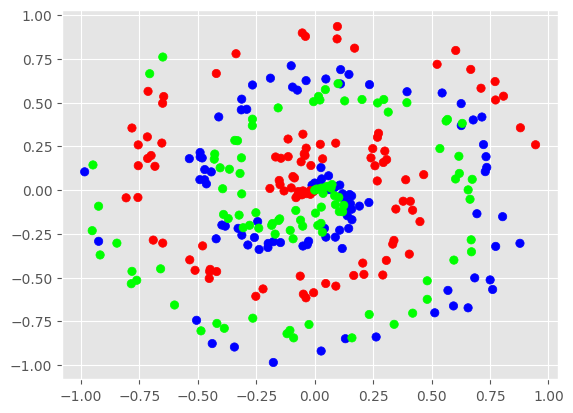

In [59]:
plt.scatter(X[:,0], X[:,1], c=y, cmap='brg')
plt.show()

In [60]:
class Layer:
    def __init__(self, n_inputs, n_neurons):
        # Setting weights to be randomly initialized and biases to 0 respectively.
        self.weights = 0.01*np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases

    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        self.dinputs = np.dot(dvalues, self.weights.T)

In [61]:
# I'm just implementing ReLU activation and Softmax activation here.
class ReLU:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs<=0] = 0

class Softmax:
    def forward(self, inputs):
        exp_values = np.exp(inputs-np.max(inputs, axis=1, keepdims=True))
        probabilities = exp_values/np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities

    def backward(self, dvalues):
        self.dinputs = np.empty_like(dvalues)

        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
            single_output = single_output.reshape(-1, -1)
            jacobian_matrix = np.diagflat(single_output)-np.dot(single_output, single_output.T)
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)

In [62]:
class Loss:
    def calculate(self, output, y):
        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)
        return data_loss

class Loss_CategoricalCrossentropy(Loss):
    def forward(self, y_pred, y_true):
        samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred, 1e-7, 1-1e-7)

        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(samples), y_true]

        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped*y_true, axis=1)

        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        labels = len(dvalues[0])

        if len(y_true.shape)==1:
            y_true = np.eye(labels)[y_true]

        self.dinputs = -y_true/dvalues
        self.dinputs = self.dinputs/samples

# Softmax Classifier - combined Softmax Activation and
# cross-entropy loss for faster backward step
class Activation_Softmax_Loss_CategoricalCrossentropy():
    def __init__(self):
        self.activation = Softmax()
        self.loss = Loss_CategoricalCrossentropy()

    def forward(self, inputs, y_true):
        self.activation.forward(inputs)
        self.output = self.activation.output
        return self.loss.calculate(self.output, y_true)

    def backward(self, dvalues, y_true):
        samples = len(dvalues)

        if len(y_true.shape)==2:
            y_true = np.argmax(y_true, axis=1)

        self.dinputs = dvalues.copy()
        self.dinputs[range(samples), y_true] -= 1
        self.dinputs = self.dinputs/samples

In [63]:
class Optimizer_SGD:
    def __init__(self, learning_rate=1.0):
        self.learning_rate = learning_rate
    def update_params(self, layer):
        layer.weights += -(self.learning_rate)*(layer.dweights)
        layer.biases += -(self.learning_rate)*(layer.dbiases)

In [64]:
dense1 = Layer(2, 64)
activation1 = ReLU()
dense2 = Layer(64, 3)
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
optimizer = Optimizer_SGD()

dense1.forward(X)
activation1.forward(dense1.output)
dense2.forward(activation1.output)

loss = loss_activation.forward(dense2.output, y)
# Output of first 3 samples:
print(loss_activation.output[:5])

# Loss Value
print('LOSS:', loss)

predictions = np.argmax(loss_activation.output, axis=1)
if len(y.shape)==2:
    y = np.argmax(y, axis=1)
accuracy = np.mean(predictions==y)

print('Accuracy:', accuracy)

[[0.33333333 0.33333333 0.33333333]
 [0.33333654 0.33333091 0.33333254]
 [0.33334001 0.33332877 0.33333122]
 [0.33333381 0.33332892 0.33333727]
 [0.33333823 0.33332352 0.33333825]]
LOSS: 1.0986235588551
Accuracy: 0.3333333333333333


In [65]:
# Backward Pass
loss_activation.backward(loss_activation.output, y)
dense2.backward(loss_activation.dinputs)
activation1.backward(dense2.dinputs)
dense1.backward(activation1.dinputs)

In [70]:
# Backpropagation for multiple iterations:
EPOCHS = 10000
for epoch in range(EPOCHS):
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    loss = loss_activation.forward(dense2.output, y)
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape)==2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions==y)

    if epoch%100==0:
        print(f'EPOCH: {epoch}', f'Accuracy: {accuracy}', f'Loss: {loss}')

    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    optimizer.update_params(dense1)
    optimizer.update_params(dense2)

EPOCH: 0 Accuracy: 0.8533333333333334 Loss: 0.3874158694113882
EPOCH: 100 Accuracy: 0.8366666666666667 Loss: 0.46785143033586557
EPOCH: 200 Accuracy: 0.8166666666666667 Loss: 0.4242717912913961
EPOCH: 300 Accuracy: 0.7766666666666666 Loss: 0.5582376685294199
EPOCH: 400 Accuracy: 0.7966666666666666 Loss: 0.4753052459315236
EPOCH: 500 Accuracy: 0.83 Loss: 0.3781184828381821
EPOCH: 600 Accuracy: 0.6933333333333334 Loss: 0.8352798604827167
EPOCH: 700 Accuracy: 0.75 Loss: 0.6705752844848485
EPOCH: 800 Accuracy: 0.81 Loss: 0.5835380953669096
EPOCH: 900 Accuracy: 0.82 Loss: 0.40758425662091385
EPOCH: 1000 Accuracy: 0.71 Loss: 0.7647602566602193
EPOCH: 1100 Accuracy: 0.8366666666666667 Loss: 0.4598992751166535
EPOCH: 1200 Accuracy: 0.8366666666666667 Loss: 0.45717241558579164
EPOCH: 1300 Accuracy: 0.8133333333333334 Loss: 0.47754140570762144
EPOCH: 1400 Accuracy: 0.8233333333333334 Loss: 0.3832797698779022
EPOCH: 1500 Accuracy: 0.81 Loss: 0.5012767060427312
EPOCH: 1600 Accuracy: 0.533333333333

In [71]:
print(predictions)


[0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 2 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 2 0 0 2 2 0 0 0 2 2 2 2
 2 2 0 2 2 2 2 0 0 2 0 2 2 2 2 0 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2
 2 0 2 0 2 0 0 0 0 2 2 2 2 0 0 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 0 2 2 2 0 2 0
 2 0 2 2]
